In [1]:
import pandas as pd
from pandas import DataFrame
from pandas import Series 
from pandas import concat
from pandas import datetime
import numpy as np
from numpy import concatenate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
#from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

<ipython-input-1-4bc7f0a147d1>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
df = pd.read_csv("GuaMusang_imputed.csv", parse_dates = ['Date'], na_values='?')
print(df['Rainfall'].isnull().sum())
#print(df.shape)

df['Date'] = pd.date_range(start='1/1/1982', end='31/12/2020')
df.set_index('Date',inplace=True)

df = df.resample('M').sum()
df

0


,Rainfall
Date,
1982-01-31,20.0
1982-02-28,67.0
1982-03-31,186.0
1982-04-30,243.0
1982-05-31,167.0
...,...
2020-08-31,198.4
2020-09-30,192.0
2020-10-31,198.4


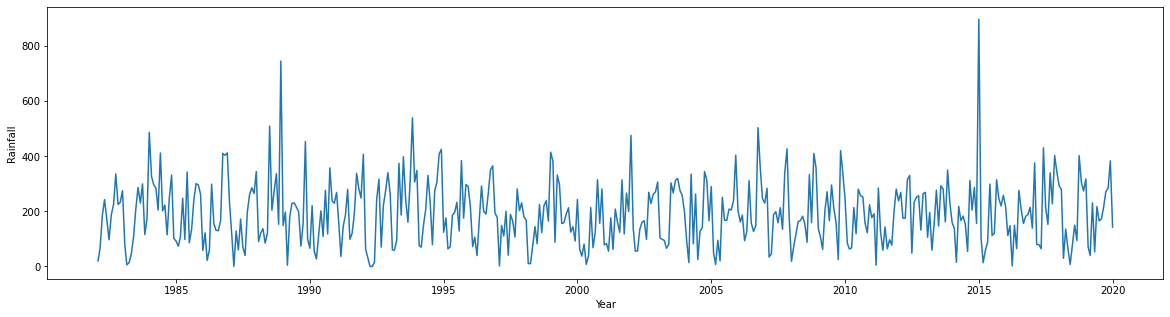

In [3]:
plt.figure(figsize=(20,5))
plt.plot(df.iloc[:-12])
plt.xlabel("Year") 
plt.ylabel("Rainfall")
plt.show()

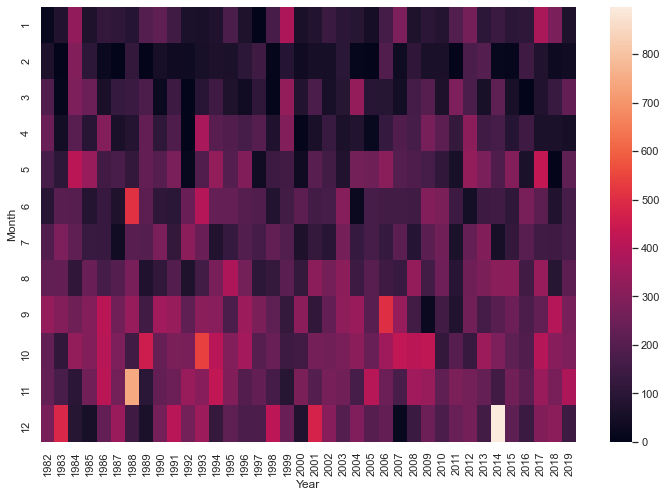

In [4]:
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})

df1 = df.reset_index()
df1['Year'] = pd.to_datetime(df1['Date']).dt.year
df1['Month'] = pd.to_datetime(df1['Date']).dt.month
df1 = df1.drop(['Date'], axis = 1).iloc[:-12].pivot("Month", "Year", "Rainfall")
#df1 = df1.pivot("Month", "Year", "Rainfall")
#df1 = df1.iloc[:-12]
ax = sns.heatmap(df1)

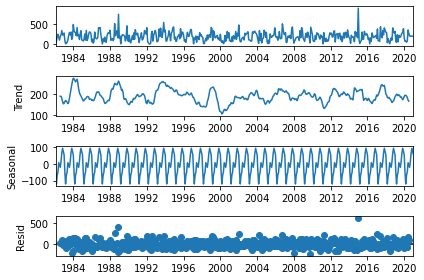

In [4]:
df_decomp = seasonal_decompose(df, model='additive')
df_decomp.plot()
plt.show()

In [5]:
df_trend = df_decomp.trend; #ARIMA
df_seasonal = df_decomp.seasonal; #ARIMA
df_resid = df_decomp.resid; #LSTM

df_arima = df_trend.add(df_seasonal);
df_arima = df_arima.fillna(0);
df_lstm = df_resid;
df_lstm = df_lstm.fillna(0);

#df_arima.to_csv('df_arima.csv', sep=',')
#df_lstm.to_csv('df_lstm.csv', sep=',')

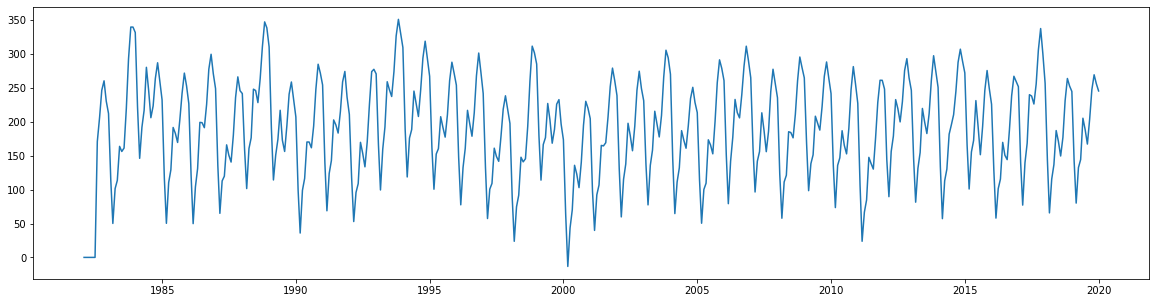

In [6]:
plt.figure(figsize=(20,5))
plt.plot(df_arima.iloc[:-12])
plt.show()

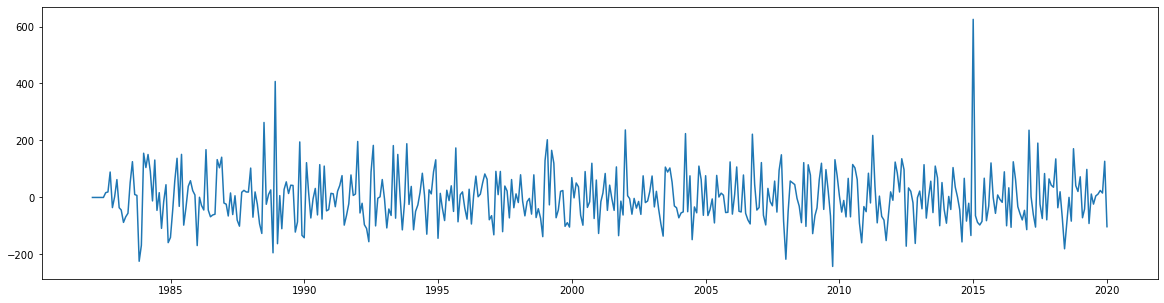

In [7]:
plt.figure(figsize=(20,5))
plt.plot(df_lstm.iloc[:-12])
plt.show()

In [8]:
def r2_det(y, yhat):
    ybar = np.sum(y)/len(y)          # or sum(y)/len(y)
    #ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    #sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    #sserror = np.sum((y - yhat)**2)
    
    sserror = sum([(yi - yihat)**2 for yi, yihat in zip(y, yhat)])
    ssreg = sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = sum([ (yi - ybar)**2 for yi in y])
    #results['determination'] = ssreg / sstot

    return 1 - (sserror / sstot)

In [9]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

#df = pd.read_csv("df_LSTM.csv",header=0, index_col=0, parse_dates=True)
df_lstm = df_lstm.iloc[:-12].values.astype('float32') #remove last year(2020)
df_lstm = df_lstm.reshape(df_lstm.shape[0], 1)

supervised = series_to_supervised(df_lstm, 12)
supervised_values = supervised.values
 
train, test = supervised_values[0:-36], supervised_values[-36:]
scaler = MinMaxScaler(feature_range=(-1, 1))


train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

#train_scaled = train_scaled[12:]

In [20]:
X_train, y_train = train_scaled[:,0:-1], train_scaled[:,-1]
X_train = X_train.reshape(X_train.shape[0], 12, 1)

X_train, y_train, X_valid, y_valid = X_train[:-84], y_train[:-84], X_train[-84:], y_train[-84:]

model = Sequential()
model.add(LSTM(200, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001))
model.fit(X_train, y_train, epochs=500, batch_size=1, validation_data=(X_valid, y_valid), verbose=2, shuffle=False)
#model.reset_states()

Epoch 1/500
324/324 - 3s - loss: 0.1519 - val_loss: 0.1131
Epoch 2/500
324/324 - 1s - loss: 0.0611 - val_loss: 0.0664
Epoch 3/500
324/324 - 1s - loss: 0.0460 - val_loss: 0.0650
Epoch 4/500
324/324 - 1s - loss: 0.0464 - val_loss: 0.0650
Epoch 5/500
324/324 - 1s - loss: 0.0461 - val_loss: 0.0649
Epoch 6/500
324/324 - 1s - loss: 0.0467 - val_loss: 0.0649
Epoch 7/500
324/324 - 1s - loss: 0.0458 - val_loss: 0.0648
Epoch 8/500
324/324 - 1s - loss: 0.0457 - val_loss: 0.0647
Epoch 9/500
324/324 - 1s - loss: 0.0453 - val_loss: 0.0647
Epoch 10/500
324/324 - 1s - loss: 0.0459 - val_loss: 0.0647
Epoch 11/500
324/324 - 1s - loss: 0.0454 - val_loss: 0.0646
Epoch 12/500
324/324 - 1s - loss: 0.0458 - val_loss: 0.0645
Epoch 13/500
324/324 - 1s - loss: 0.0455 - val_loss: 0.0644
Epoch 14/500
324/324 - 1s - loss: 0.0455 - val_loss: 0.0643
Epoch 15/500
324/324 - 1s - loss: 0.0462 - val_loss: 0.0643
Epoch 16/500
324/324 - 1s - loss: 0.0457 - val_loss: 0.0642
Epoch 17/500
324/324 - 1s - loss: 0.0450 - val_lo

324/324 - 1s - loss: 0.0400 - val_loss: 0.0540
Epoch 138/500
324/324 - 1s - loss: 0.0386 - val_loss: 0.0538
Epoch 139/500
324/324 - 1s - loss: 0.0382 - val_loss: 0.0539
Epoch 140/500
324/324 - 1s - loss: 0.0389 - val_loss: 0.0537
Epoch 141/500
324/324 - 1s - loss: 0.0391 - val_loss: 0.0538
Epoch 142/500
324/324 - 1s - loss: 0.0389 - val_loss: 0.0536
Epoch 143/500
324/324 - 1s - loss: 0.0392 - val_loss: 0.0537
Epoch 144/500
324/324 - 1s - loss: 0.0399 - val_loss: 0.0536
Epoch 145/500
324/324 - 1s - loss: 0.0392 - val_loss: 0.0535
Epoch 146/500
324/324 - 1s - loss: 0.0394 - val_loss: 0.0535
Epoch 147/500
324/324 - 1s - loss: 0.0390 - val_loss: 0.0535
Epoch 148/500
324/324 - 1s - loss: 0.0394 - val_loss: 0.0534
Epoch 149/500
324/324 - 1s - loss: 0.0385 - val_loss: 0.0534
Epoch 150/500
324/324 - 1s - loss: 0.0392 - val_loss: 0.0533
Epoch 151/500
324/324 - 1s - loss: 0.0384 - val_loss: 0.0532
Epoch 152/500
324/324 - 1s - loss: 0.0395 - val_loss: 0.0531
Epoch 153/500
324/324 - 1s - loss: 0.0

Epoch 272/500
324/324 - 2s - loss: 0.0361 - val_loss: 0.0498
Epoch 273/500
324/324 - 1s - loss: 0.0363 - val_loss: 0.0500
Epoch 274/500
324/324 - 1s - loss: 0.0379 - val_loss: 0.0498
Epoch 275/500
324/324 - 1s - loss: 0.0380 - val_loss: 0.0499
Epoch 276/500
324/324 - 1s - loss: 0.0369 - val_loss: 0.0498
Epoch 277/500
324/324 - 1s - loss: 0.0364 - val_loss: 0.0498
Epoch 278/500
324/324 - 1s - loss: 0.0378 - val_loss: 0.0499
Epoch 279/500
324/324 - 1s - loss: 0.0373 - val_loss: 0.0498
Epoch 280/500
324/324 - 1s - loss: 0.0375 - val_loss: 0.0498
Epoch 281/500
324/324 - 1s - loss: 0.0363 - val_loss: 0.0498
Epoch 282/500
324/324 - 1s - loss: 0.0365 - val_loss: 0.0499
Epoch 283/500
324/324 - 1s - loss: 0.0374 - val_loss: 0.0498
Epoch 284/500
324/324 - 1s - loss: 0.0368 - val_loss: 0.0498
Epoch 285/500
324/324 - 1s - loss: 0.0361 - val_loss: 0.0498
Epoch 286/500
324/324 - 1s - loss: 0.0364 - val_loss: 0.0498
Epoch 287/500
324/324 - 1s - loss: 0.0372 - val_loss: 0.0498
Epoch 288/500
324/324 - 

Epoch 407/500
324/324 - 1s - loss: 0.0368 - val_loss: 0.0491
Epoch 408/500
324/324 - 1s - loss: 0.0362 - val_loss: 0.0492
Epoch 409/500
324/324 - 1s - loss: 0.0364 - val_loss: 0.0492
Epoch 410/500
324/324 - 1s - loss: 0.0366 - val_loss: 0.0490
Epoch 411/500
324/324 - 1s - loss: 0.0355 - val_loss: 0.0491
Epoch 412/500
324/324 - 1s - loss: 0.0354 - val_loss: 0.0491
Epoch 413/500
324/324 - 1s - loss: 0.0373 - val_loss: 0.0490
Epoch 414/500
324/324 - 1s - loss: 0.0363 - val_loss: 0.0490
Epoch 415/500
324/324 - 1s - loss: 0.0356 - val_loss: 0.0493
Epoch 416/500
324/324 - 1s - loss: 0.0359 - val_loss: 0.0490
Epoch 417/500
324/324 - 1s - loss: 0.0367 - val_loss: 0.0490
Epoch 418/500
324/324 - 1s - loss: 0.0367 - val_loss: 0.0491
Epoch 419/500
324/324 - 1s - loss: 0.0365 - val_loss: 0.0491
Epoch 420/500
324/324 - 1s - loss: 0.0355 - val_loss: 0.0489
Epoch 421/500
324/324 - 1s - loss: 0.0363 - val_loss: 0.0489
Epoch 422/500
324/324 - 1s - loss: 0.0367 - val_loss: 0.0491
Epoch 423/500
324/324 - 

In [21]:
X_test, y_test = test_scaled[:,0:-1], test_scaled[:,-1]
X_test = X_test.reshape(X_test.shape[0], 12, 1)

yhat = model.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], 12)
yhat = concatenate((X_test, yhat), axis=1)
yhat = scaler.inverse_transform(yhat)
predicted = yhat[:,-1]

RMSE: 82.591
MAE: 66.867
R2: 0.165


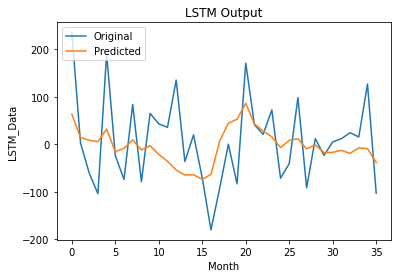

In [22]:
Original_lstm = df_lstm[-36:];
Predicted_lstm = predicted;
print('RMSE: %.3f' % sqrt(mean_squared_error(df_lstm[-36:], predicted)))
print('MAE: %.3f' % mean_absolute_error(df_lstm[-36:], predicted))
print('R2: %.3f' % r2_score(df_lstm[-36:], predicted))

plt.plot(df_lstm[-36:], label='Original')
plt.plot(predicted, label='Predicted')
plt.title("LSTM Output") 
plt.xlabel("Month") 
plt.ylabel("LSTM_Data")
plt.legend(loc="upper left")
plt.show()

In [23]:
# ARIMA Model

#df_arima = pd.read_csv("df_arima.csv",header=0, index_col=0, parse_dates=True)
df_arima = df_arima.iloc[:-12]

# split data for ARIMA
data_all_values_arima = df_arima.values

data_train_split_arima = 420  
data_train_arima = data_all_values_arima[:data_train_split_arima]
data_test_arima = data_all_values_arima[data_train_split_arima:]

history_arima = [x for x in data_train_arima]
predictions_arima = list()
for t in range(len(data_test_arima)):
    model_arima = SARIMAX(history_arima, order=(1, 0, 1), seasonal_order=(2, 1, 2, 12), trend='n',
                          enforce_stationarity=False, enforce_invertibility=False) 
    model_fit_arima = model_arima.fit(disp=0)
    #output_arima = model_fit_arima.forecast()
    yhat = model_fit_arima.predict(len(history_arima), len(history_arima))
    if yhat<0:
        yhat=0
    #yhat_arima = output_arima[0]
    predictions_arima.append(yhat)
    obs_arima = data_test_arima[t]
    history_arima.append(obs_arima)

# Plot graph
data_test_arima = data_test_arima[:len(data_test_arima)];
predictions_arima = predictions_arima[:len(predictions_arima)]

# calculate RMSE
rmse_arima = sqrt(mean_squared_error(data_test_arima, predictions_arima))
print('Test RMSE: %.3f' % rmse_arima)

Test RMSE: 3.844


ARIMA RMSE: 3.844
ARIMA MAE: 3.114
ARIMA rsquare: 0.997


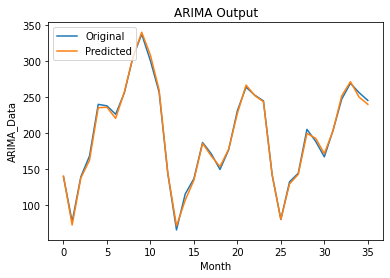

In [24]:
Original_arima = data_test_arima;
Predicted_arima = predictions_arima;
print('ARIMA RMSE: %.3f' % sqrt(mean_squared_error(data_test_arima, predictions_arima)))
print('ARIMA MAE: %.3f' % mean_absolute_error(data_test_arima, predictions_arima))
print('ARIMA rsquare: %.3f' % r2_score(data_test_arima, predictions_arima))

plt.plot(data_test_arima, label="Original")
plt.plot(predictions_arima, label="Predicted")
plt.title("ARIMA Output") 
plt.xlabel("Month") 
plt.ylabel("ARIMA_Data")
plt.legend(loc="upper left")
plt.show()

Combined RMSE: 82.542
Combined MAE: 66.414
Combined rsquare: 0.542


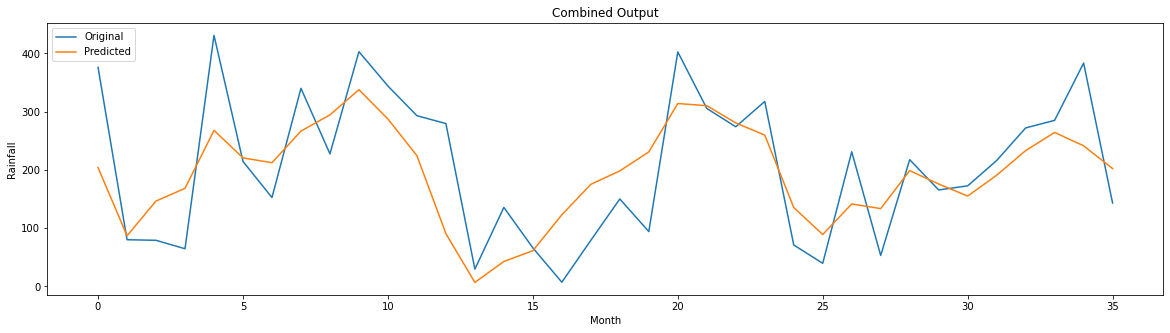

In [25]:
# Combined

Original_arima_array = np.array(Original_arima);
Predicted_arima_array = np.array(Predicted_arima);
Original_arima= Original_arima_array[:].transpose().flatten();
Predicted_arima= Predicted_arima_array[:].transpose().flatten();

Original_combined = np.add(np.array(Original_lstm.transpose().flatten()),Original_arima);
Predicted_combined = np.add(np.array(Predicted_lstm),Predicted_arima);

print('Combined RMSE: %.3f' % sqrt(mean_squared_error(Original_combined, Predicted_combined)))
print('Combined MAE: %.3f' % mean_absolute_error(Original_combined, Predicted_combined))
print('Combined rsquare: %.3f' % r2_score(Original_combined, Predicted_combined))

plt.figure(figsize=(20,5))
plt.plot(Original_combined, label='Original')
plt.plot(Predicted_combined, label='Predicted')
plt.title("Combined Output") 
plt.xlabel("Month") 
plt.ylabel("Rainfall")
plt.legend(loc="upper left")
plt.show()